# Homework 1 - Data mining technology for business and society

Cristina Menghini - StudentID : 1527821

The aim of this homework is to configure a search engine on two particular collections of documents: 
* ‘Cranfield’ 
* ‘Time’ 

In particular we want to find the best configuration(in terms of stemming method and scorer function) for the search engine, using the available Ground-Truth data. In order to evaluate the search engine performance I use the precision-at-k metric, P@k.

## Build up the search engine respect to the two collections and evaluate its precision

According to the software I use to do it, I need to use the command line. Here the necessary code follows.

* First of all I set the class-path that once set up allows me to use the software and define some useful variables.

* Then I define the loop to authomatically:
    - Create a collection on the set of html documents with MG4J;
    - Create an inverted index (with MG4J) on the collection trying different stemming methods;
    - Obtain results for each query trying different scorer functions: CountScorer, TfIdfScorer and BM25Scorer;
    - Use the Ground-Truth to evaluate the performance of each stemmer-scorer configuration.

In [ ]:
%%sh
source set-my-classpath.sh
dataset=("Cranfield" "Time")
stemmers=("--downcase" "it.unimi.di.big.mg4j.index.snowball.EnglishStemmer" "homework.EnglishStemmerStopwords")
scorers=("CountScorer" "TfIdfScorer" "BM25Scorer")
name=("cran" "time")
i=0
for ds in ${dataset[@]};
do
        mv "$ds"_DATASET/${name[$i]}_all_queries.tsv "$ds"_DATASET/"$ds"_all_queries.tsv
        mv "$ds"_DATASET/${name[$i]}_Ground_Truth.tsv "$ds"_DATASET/"$ds"_Ground_Truth.tsv
        echo "Do computations on $ds"
        for st in ${stemmers[@]};
        do
            mkdir "$ds"_DATASET/"$ds"_"$st"
            echo "Build collection"
            find "$ds"_DATASET -iname \*.html | java it.unimi.di.big.mg4j.document.FileSetDocumentCollection -f HtmlDocumentFactory -p encoding=UTF-8 "$ds"_DATASET/"$ds"_"$st"/"$ds".collection
            for sc in ${scorers[@]};
            do 
                echo " Stemmer $st : "
                mkdir "$ds"_DATASET/"$ds"_"$st"/"$st"_"$sc"
                echo " Build the index using $st : "
                if [ "$st" == "${stemmers[0]}" ];
                then java it.unimi.di.big.mg4j.tool.IndexBuilder $st -S "$ds"_DATASET/"$ds"_"$st"/"$ds".collection "$ds"_DATASET/"$ds"_"$st"/"$ds";
                else java it.unimi.di.big.mg4j.tool.IndexBuilder -t $st -S "$ds"_DATASET/"$ds"_"$st"/"$ds".collection "$ds"_DATASET/"$ds"_"$st"/"$ds";
                fi;                
                echo "Run all queries and score them using $sc:"
                java homework.RunAllQueries_HW "$ds"_DATASET/"$ds"_"$st"/"$ds" "$ds"_DATASET/"$ds"_all_queries.tsv "$sc" "1:2" "$ds"_DATASET/"$ds"_"$st"/"$st"_"$sc"/output_"$st"_"$sc".tsv
                echo "Execute the Python script to evaluate the extended precision of the search engine:"
                python patkpython.py $st $sc $ds
            done
        done
        ((i++))
done
echo "Finish, let’s plot our result!"

To determine the average P@k over all queries in the query set, taking in input the search engine results for each query in the query set and the Ground-Truth file. I write a software in Python that is saved in the folder as 'patkpython.py'. It is directly executed in the above piece of code. I copy below the code to have a clear ideo of what goes on in the previous loop when the file is recalled.

*N.B. I put the code below in order to avoid you to go from a file to another. Hence, the cell should not be runned here in Jupyter.*

According to the script I would like to stress that I define the precision of the search engine respect to the queries and k as follows:

Given
* RetrD_k : the set of retrieved document( up to k) by the engine to answer a query;
* RelD : the set of relevant document to answer the query;
* k : number of retrieved document taken into account

In [69]:
%%latex
$$P@k = \frac{RetrD \bigcap RelD}{min\{k, RelD\}}$$

<IPython.core.display.Latex object>

I divide by the minimun in order to get precision equal to 1 whether, in the set of retrieved documents there are all those that are also in the relevant document set and the number of that documents is smaller that k. If I don't divide by the minimum I would get a value smaller than 1 that would not describe the "real" precision of the search engine that concretely gives back all the documents considered relevant.

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sys import argv
import pickle
from collections import defaultdict

In [152]:
class create_query_dict(object):
    """This class returns a dictionary whose keys are the query id and the values the list of documents related to the
    query."""
    
    def __init__(self, q_array):
        
        """ An instance created by that class is characterized by the following attribute:
        - q_array : is the n-dimentional array thhat contains the information that are goint to bu put into the
          dictionary"""
        
        self.q_array = q_array
    
    def dic_query_result(self):
        """This method returns dictionary whose keys are the query id and the values the list of documents related to the
        query."""
    
    # Zip two columns of the multidimensional array
        query_doc_id = zip(self.q_array[:,0], self.q_array[:,1])
    # Create an empry dictionary
        dic = {}
    # For each tuple of the zipped variable
        for q in query_doc_id:
        # whether doesn't exist create a key with a list as value and append to the list the sencond element of the tuple
            dic.setdefault(q[0],[]).append(q[1])
    # Return the filled dictionary
        return(dic)

In [153]:
def precision_at_k(k_list):
    """This function returns the precision of each query respect to a fixed K. Precisely it gives back a dictionary
    {key = k : value = precision}.
    - k_list : is the list of k's for which I want to compute the precision."""
    precision = {}
    # For each level of precision k = {1,3,5,10}
    for K in k:
        precision[K] = {}
        # For each query
        for q in queries:
            try:
                # Pick the set of the retrieved documents(k)
                set_retrieved = set(query_dic[q][:K])
                # Get the set of the relevant document for the q query
                set_relevant = set(relevant_query[q])
                # Intersect the two sets to obtain the number of relevant retrieved documents
                num_relevant_retrieved = len(set_retrieved.intersection(set_relevant))
                # Compute the precision of the
                precision[K][q] = num_relevant_retrieved*1.0/min(K,len(set_relevant))
            except:
                # Whether some query has no a grouf truth repeat the previous procedure but with an empty relevant document set
                set_relevant = []
                num_relevant_retrieved = len(set_retrieved.intersection(set_relevant))
                precision[K][q] = 0
    
    return(precision)

In [ ]:
# Define the arguments of the script
script , stem, scor, ct = argv

# Load data
query_result = np.array(pd.read_csv(str(ct)+'_DATASET/'+str(ct)+'_'+str(stem)+'/'+str(stem)+'_'+str(scor)+"/output_"+str(stem)+"_"+str(scor)+'.tsv', sep = '\t'))
ground_truth = np.array(pd.read_csv(str(ct)+'_DATASET/'+str(ct)+'_Ground_Truth.tsv', sep = '\t'))

# Define the list of K's
k = [1,3,5,10]

query_dic = create_query_dict(query_result).dic_query_result()
relevant_query = create_query_dict(ground_truth).dic_query_result()
# Define the list of queries
queries = query_dic.keys()
# Compute the precision of each query
precision_k = precision_at_k(k)
# COmpute the averege precision of the queries
average_precision = {K : np.array((precision_k[K].values())).mean() for K in k}
# Store the variable average_precision in a file.
pickle.dump( average_precision, open(str(ct)+'_DATASET/'+str(ct)+'_'+str(stem)+'/'+str(ct)+'_'+str(scor)+'avg_'+str(stem)+'_'+str(scor)+'.p', 'wb')) # Store the variable average_precision in a file.

print 'Done'

### Once we get the results.. Plot them to see how the story ends!

In [141]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
%matplotlib inline  

In [142]:
# Define variables to define the files I want to load
dataset=["Cranfield", "Time"]
stemmers=["--downcase", "it.unimi.di.big.mg4j.index.snowball.EnglishStemmer", "homework.EnglishStemmerStopwords"]
scorers=["CountScorer", "TfIdfScorer", "BM25Scorer"]
colours = ['Red','Darkred','Pink','DeepPink','Lime','Coral','Olive','SteelBlue','Yellow','Orange']
k = [1,3,5,10]

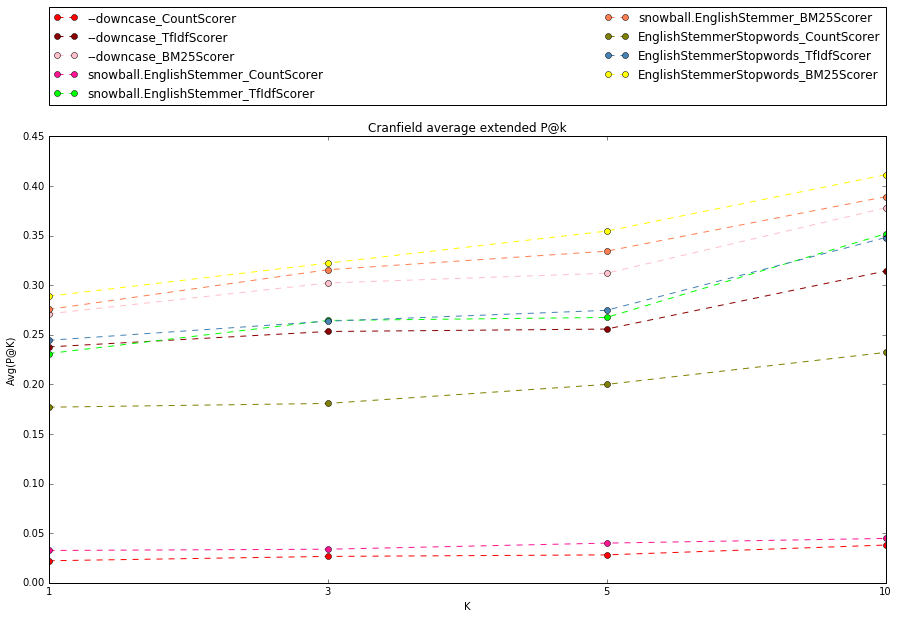

In [176]:
# Plot the results of Cranfield
plt.figure(figsize=(15,8), dpi=80)
i = 0
for s in stemmers:
    for sc in scorers:
        avg_pre = pickle.load(open(str(dataset[0])+'_DATASET/'+str(dataset[0])+'_'+str(s)+'/'+str(dataset[0])+'_'+str(sc)+'avg_'+str(s)+'_'+str(sc)+'.p', 'rb'))
        if str(s) == "--downcase":
            plt.plot( sorted(avg_pre.values()), marker = 'o', color=colours[i], linestyle = '--', label=str(s)+'_'+str(sc))
        else:
            plt.plot( sorted(avg_pre.values()), marker = 'o', color=colours[i],linestyle = '--', label=str(s)[-23:]+'_'+str(sc))
        plt.ylabel('Avg(P@K)')
        plt.xlabel('K')
        plt.legend(bbox_to_anchor=(0., 1.07, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
        i += 1
plt.xticks(x, k)
plt.title('Cranfield average extended P@k')
plt.show()

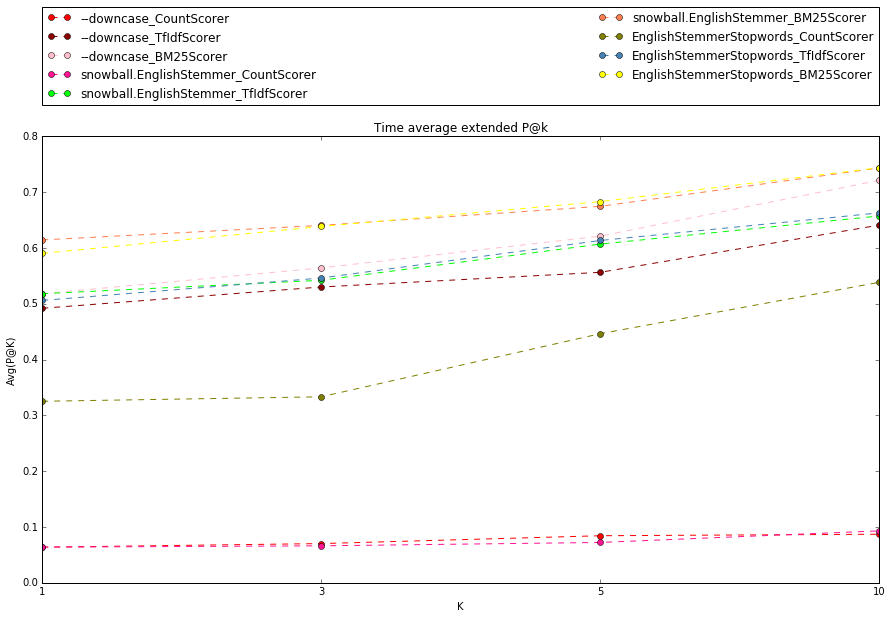

In [175]:
# Plot the results of Time
plt.figure(figsize=(15,8), dpi=80)
i = 0
for s in stemmers:
    for sc in scorers:
        avg_pre = pickle.load(open(str(dataset[1])+'_DATASET/'+str(dataset[1])+'_'+str(s)+'/'+str(dataset[1])+'_'+str(sc)+'avg_'+str(s)+'_'+str(sc)+'.p', 'rb'))
        if str(s) == "--downcase":
            plt.plot( sorted(avg_pre.values()), marker = 'o', color=colours[i], linestyle = '--', label=str(s)+'_'+str(sc))
        else:
            plt.plot( sorted(avg_pre.values()), marker = 'o', color=colours[i],linestyle = '--', label=str(s)[-23:]+'_'+str(sc))
        plt.ylabel('Avg(P@K)')
        plt.xlabel('K')
        plt.legend(bbox_to_anchor=(0., 1.07, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
        i += 1
plt.xticks(x, k)
plt.title('Time average extended P@k')
plt.show()

### Statistics on Cranfield 

1. (a) The number of documents that composed the Crafield dataset is:

In [161]:
import os
print len(os.listdir('Cranfield_DATASET/cran'))

1400


1. (b) The number of queries is:

In [162]:
len(set(np.array(pd.read_csv('Cranfield_DATASET/Cranfield_--downcase/--downcase_BM25Scorer/output_--downcase_BM25Scorer.tsv', sep = '\t'))[:,0]))

225

### Statistics on Time

1. (a) The number of documents that composed the Crafield dataset is:

In [163]:
print len(os.listdir('Time_DATASET/time'))

424


1. (b) The number of queries is:

In [164]:
len(set(np.array(pd.read_csv('Time_DATASET/Time_--downcase/--downcase_BM25Scorer/output_--downcase_BM25Scorer.tsv', sep = '\t'))[:,0]))

83

### Stemmers used

1. Default stemmer
2. Stemmer for the English language 
3. Stemmer for the English language able to filter stopwords

### Scorer functions used

1. NumOccurrences( "CountScorer") scorer function: a trivial scorer function that computes the score by adding the number of occurrences within the current document of each query term.
2. TF/IDF( "TfIdfScorer") : a well known scorer function.
3. BM25( "BM25Scorer") : beyond TF/IDF, more information at 

### Conclusions - Cranfield

1. Referring to *Cranfield* the best scorer-stemmer combination is the one the glue BM25Scorer and the EnglishStemmerStopwords
2. 
3. 

### Conclusions - Time